In [1]:
%matplotlib inline
import pandas as pd
import urllib as ur
import json
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

## Requisitando os carros e filtrando com base do seu tipo (normais, elétricos e híbridos).

Iremos coletar os ids de cada veículos e separá-los em movidos a gasolina, elétrico e híbrido.
Tal classificação tem como objetivo verificar o comportamento de uso para cada tipo de veículo.

In [2]:
# Requisição a lista de carros e suas informações
response = ur.request.urlopen('https://bookit.modo.coop/api/v2/car_list').read().decode('UTF-8')
json_cars = json.loads(response)

In [3]:
# Adquirindo os ids de todos os carros
car_ids = list(json_cars['Response']['Cars'].keys())

In [4]:
electric = []

# Separando por carro o seu tipo, sendo hibrido ou elétrico
for car in car_ids:
    try:
        accessories = list(json_cars['Response']['Cars'][str(car)]['Accessories'])

        if ('hybrid' in accessories):
            electric.append([int(car), 'hybrid'])
        if ('electric car' in accessories):
            electric.append([int(car), 'electric'])
    except:
        continue
        
# Lista com todos os veiculos elétricos e hibridos
electric = pd.DataFrame(electric, columns=['car_id', 'type'])

## Coletando a duração de cada viagem para carros normais, elétricos e híbridos.

In [5]:
# Lendo csv de intervalos de ociosidade e ocupação
dfOccupied = pd.read_csv('../paper/data/occupied_duration.csv')
dfParked = pd.read_csv('../paper/data/parked_duration.csv')

In [6]:
def Hour_Diff(h1,h2):
    """
    Faz a diferença entre duas horas dadas e retorna em minutos
    
    Parameters
    ----------
    h1, h2 : unix timestamp
        Hora inicio e fim para ser feito o cálculo da diferença
        
    Returns
    ---------
    diff : float
        Diferença entre as duas horas dadas em minutos
        
    """
    
    h1Aux = datetime.datetime.fromtimestamp(h1)
    h2Aux = datetime.datetime.fromtimestamp(h2)
    diff = abs((h1Aux - h2Aux)).total_seconds()/60
    
    return diff

In [7]:
# Filtra os intervalos de ocupação dos carros híbridos e elétricos

electric_occupied = []
hybrid_occupied = []

for i in range(len(electric)):
    occupied = dfOccupied[dfOccupied['car_id'] == electric['car_id'].iloc[i]]

    if (electric['type'].iloc[i] == 'hybrid'):
        for j in range(len(occupied)):
            hybrid_occupied.append([occupied['car_id'].iloc[j] ,occupied['start'].iloc[j], 
                                   occupied['end'].iloc[j],occupied['duration'].iloc[j]])
        continue
    if (electric['type'].iloc[i] == 'electric'):
        for j in range(len(occupied)):
            electric_occupied.append([occupied['car_id'].iloc[j] ,occupied['start'].iloc[j], 
                                     occupied['end'].iloc[j], occupied['duration'].iloc[j]])
        continue

hybrid_occupied = pd.DataFrame(hybrid_occupied, columns=['car_id', 'start', 'end', 'duration'])
electric_occupied = pd.DataFrame(electric_occupied, columns=['car_id', 'start', 'end', 'duration'])

# Filtra o tempo de ociosidade dos carros híbridos e elétricos

electric_parked = []
hybrid_parked = []

for i in range(len(electric)):
    parked = dfParked[dfParked['car_id'] == electric['car_id'].iloc[i]]

    if (electric['type'].iloc[i] == 'hybrid'):
        for j in range(len(parked)):
            hybrid_parked.append([parked['car_id'].iloc[j] ,parked['start'].iloc[j], 
                                  parked['end'].iloc[j], parked['duration'].iloc[j]])
        continue
    if (electric['type'].iloc[i] == 'electric'):
        for j in range(len(parked)):
            electric_parked.append([parked['car_id'].iloc[j] ,parked['start'].iloc[j], 
                                    parked['end'].iloc[j], parked['duration'].iloc[j]])
        continue

hybrid_occupied = pd.DataFrame(hybrid_occupied, columns=['car_id', 'start', 'end', 'duration'])
electric_occupied = pd.DataFrame(electric_occupied, columns=['car_id', 'start', 'end', 'duration'])
hybrid_parked = pd.DataFrame(hybrid_parked, columns=['car_id', 'start', 'end', 'duration'])
electric_parked = pd.DataFrame(electric_parked, columns=['car_id', 'start', 'end', 'duration'])

In [8]:
# Filtrando tempo de ocupação e tempo de ociosidade de carros normais
normal_cars_occupied = []

for i in range(len(dfOccupied)):
    # Se o veiculo não está na lista dos elétricos e hibridos ele é a gasolina
    if (dfOccupied['car_id'].iloc[i] not in list(electric['car_id'])):
        normal_cars_occupied.append([dfOccupied['car_id'].iloc[i], dfOccupied['start'].iloc[i], 
                                    dfOccupied['end'].iloc[i], dfOccupied['duration'].iloc[i]])

normal_cars_occupied = pd.DataFrame(normal_cars_occupied, columns=['car_id', 'start', 'end', 'duration'])


normal_cars_parked = []

for i in range(len(dfParked)):
    # Se o veiculo não está na lista dos elétricos e hibridos ele é a gasolina
    if (dfParked['car_id'].iloc[i] not in list(electric['car_id'])):
        normal_cars_parked.append([dfParked['car_id'].iloc[i], dfParked['start'].iloc[i], 
                                    dfParked['end'].iloc[i], dfParked['duration'].iloc[i]])

normal_cars_parked = pd.DataFrame(normal_cars_parked, columns=['car_id', 'start', 'end', 'duration'])


## Plotagem dos CDFs.

Iremos plotar curvas de distribuições acumuladas a fim de verificar mais claramente a porcentagem de veículos ocupados para até dada duração de tempo de ocupação.

In [9]:
def cdf(df):
    """
    Calcula valores de todas as coordenadas (x,y) para uma CDF.
    
    Parameters
    -----------
    df : float list, pandas.DataFrame
        Lista de valores de durações para ser feita a CDF.
    
    Returns
    ---------
    x, y: float list
        Lista de todas as coordenadas da CDF.
        
    """
    
    df = df.sort_values(by='duration')
    values = df['duration']
    
    x = []
    y = []

    total = float(len(values))
    cnt = 0
    last = values.iloc[0]
    for data in values:
        if data != last:
            x.append(last)
            y.append(cnt/total)
            cnt += 1
            last = data
        else:
            cnt += 1
    x.append(last)
    y.append(cnt/total)
    
    return x, y

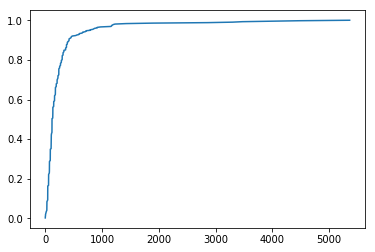

In [10]:
# CDF Ocupado de carros elétricos 
x, y = cdf(electric_occupied.sort_values(by='duration'))
plt.plot(x,y)

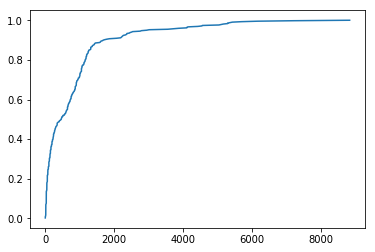

In [11]:
# CDF Ociosidade de carros elétricos
x, y = cdf(electric_parked.sort_values(by='duration'))
plt.plot(x,y)

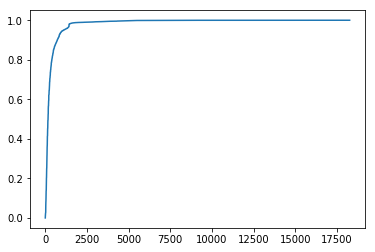

In [12]:
# CDF Ocupação de carros Híbridos
x, y = cdf(hybrid_occupied.sort_values(by='duration'))
plt.plot(x,y)

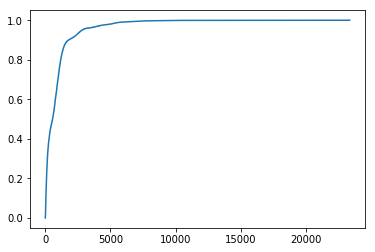

In [13]:
# CDF Ociosidade de carros Híbridos
x, y = cdf(hybrid_parked.sort_values(by=['duration']))
plt.plot(x,y)

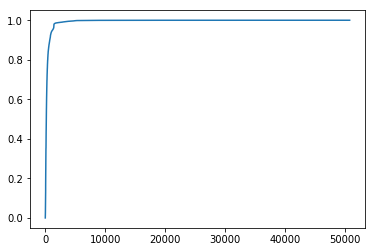

In [14]:
# CDF Ocupação de carros normais
x, y = cdf(normal_cars_occupied.sort_values(by=['duration']))
plt.plot(x,y)

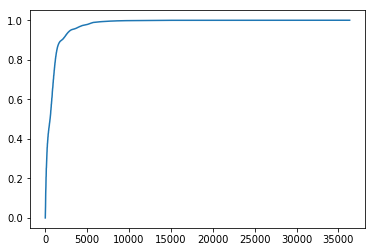

In [15]:
# CDF Viagens de carros normais
x, y = cdf(normal_cars_parked.sort_values(by='duration'))
plt.plot(x,y)

In [12]:
# Lendo dados após fitting

parked_pareto = pd.read_csv('../paper/data/idle-fitting/1_pareto.csv', usecols=[1,2])
parked_weibull = pd.read_csv('../paper/data/idle-fitting/1_weibull.csv', usecols=[1,2])
parked_lnorm = pd.read_csv('../paper/data/idle-fitting/1_lnorm.csv', usecols=[1,2])
busy_pareto = pd.read_csv('../paper/data/busy-fitting/1_pareto.csv', usecols=[1,2])
busy_weibull = pd.read_csv('../paper/data/busy-fitting/1_weibull.csv', usecols=[1,2])
busy_lnorm = pd.read_csv('../paper/data/busy-fitting/1_lnorm.csv', usecols=[1,2])

In [14]:
len(dfParked[dfParked['duration'] <= 5400])/len(dfParked)

0.9846269705793754

In [16]:
# Selecionando somente os valores menores ou iguais a 5400 minutos
# assim padronizando as curvas a fim de facilitar a visualização e desconsiderar outliers

normal_cars_occupied = normal_cars_occupied[normal_cars_occupied['duration'] <= 5400]
normal_cars_parked = normal_cars_parked[normal_cars_parked['duration'] <= 5400]
electric_occupied = electric_occupied[electric_occupied['duration'] <= 5400]
electric_parked = electric_parked[electric_parked['duration'] <= 5400]
hybrid_occupied = hybrid_occupied[hybrid_occupied['duration'] <= 5400]
hybrid_parked = hybrid_parked[hybrid_parked['duration'] <= 5400]
# parked_pareto = parked_pareto[parked_pareto['x'] <= 5400]
# parked_weibull = parked_weibull[parked_weibull['x'] <= 5400]
# parked_lnorm = parked_lnorm[parked_lnorm['x'] <= 5400]
# busy_pareto = busy_pareto[busy_pareto['x'] <= 5400]
# busy_weibull = busy_weibull[busy_weibull['x'] <= 5400]
# busy_lnorm = busy_lnorm[busy_lnorm['x'] <= 5400]

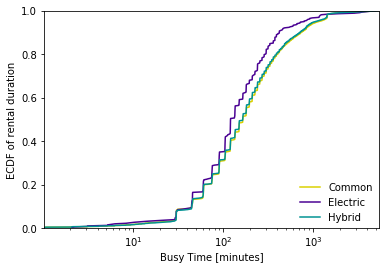

In [17]:
fig, ax = plt.subplots()

x, y = cdf(normal_cars_occupied.sort_values(by=['duration']))
ax.plot(x,y, label='Common', c = '#dbd100')#, marker='o')#, markevery=[470,1000,1800,2500,3600,5000,6300,7200,
                                          #           7350,7400,7500])


x, y = cdf(electric_occupied.sort_values(by='duration'))
ax.plot(x,y, label='Electric', c = '#490092')#, marker='^')#, markevery=[10,35,70,90,130,150,170,190,195,198,
                                             #           200,201])


x, y = cdf(hybrid_occupied.sort_values(by='duration'))
ax.plot(x,y, label='Hybrid', c = '#009292')#, marker='s')#, markevery=[150,450,750,1200,1800,2500,3000,3300,
                                            #           3500,3520,3540,3570])

# ax.plot(busy_pareto['x'], busy_pareto['y'], label='Fitted Pareto', linestyle='--')

# ax.plot(busy_weibull['x'], busy_weibull['y'], label='Fitted Weibull', c='black', linestyle=':')


# Modificando os labels dos minutos
ax.xaxis.set_ticks(np.arange(0, 6000, 720))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,100,12)

ax.set_xticklabels(labels)

ax.legend(loc=4, borderaxespad=0.2, frameon=False)
ax.set_ylabel('ECDF of rental duration')
ax.set_xlabel('Busy Time [minutes]')
ax.set_xlim(min(x),max(x))
ax.set_ylim(0,1)
ax.set_xscale('log')

plt.savefig('../paper/plots/busyCDF.png', bbox_inches='tight')
plt.show()

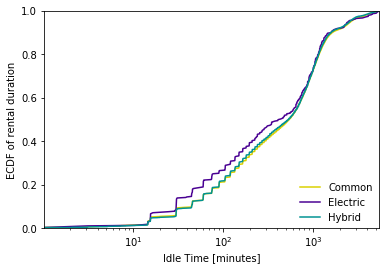

In [18]:
fig, ax = plt.subplots()

x, y = cdf(normal_cars_parked.sort_values(by=['duration']))
ax.plot(x,y, label='Common', c = '#dbd100')#, marker='o')#, markevery=[470,1000,1800,2500,3600,5000,6300,7200,
                                          #           7350,7400,7500])


x, y = cdf(electric_parked.sort_values(by='duration'))
ax.plot(x,y, label='Electric', c = '#490092')#, marker='^')#, markevery=[10,35,70,90,130,150,170,190,195,198,
                                             #           200,201])


x, y = cdf(hybrid_parked.sort_values(by='duration'))
ax.plot(x,y, label='Hybrid', c = '#009292')#, marker='s')#, markevery=[150,450,750,1200,1800,2500,3000,3300,
                                            #           3500,3520,3540,3570])

# ax.plot(busy_pareto['x'], busy_pareto['y'], label='Fitted Pareto', linestyle='--')

# ax.plot(busy_weibull['x'], busy_weibull['y'], label='Fitted Weibull', c='black', linestyle=':')


# Modificando os labels dos minutos
ax.xaxis.set_ticks(np.arange(0, 6000, 720))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,100,12)

ax.set_xticklabels(labels)

ax.legend(loc=4, borderaxespad=0.2, frameon=False)
ax.set_ylabel('ECDF of rental duration')
ax.set_xlabel('Idle Time [minutes]')
ax.set_xlim(min(x),max(x))
ax.set_ylim(0,1)
ax.set_xscale('log')

plt.savefig('../paper/plots/idleCDF.png', bbox_inches='tight')
plt.show()

## Tarde e noite para dias de semana

Estamos separando as reservas que iniciaram em certos horários, que foram observados como de pico em dias de semana, sendo o intervalo de 11 AM até 4 PM e de 7 PM até 8 PM.

In [21]:
tarde = []
noite = []

for i in range(len(dfOccupied)):
    start = dfOccupied['start'].iloc[i]
    hora = datetime.datetime.fromtimestamp(start).hour
    dia = int(datetime.datetime.fromtimestamp(start).strftime('%w'))
    
    if ((hora >= 11 and hora <= 16) and (dia > 0 and dia < 6)):
        tarde.append([dfOccupied['car_id'].iloc[i], dfOccupied['start'].iloc[i], 
                      dfOccupied['duration'].iloc[i]])
    
    elif ((hora >= 19 and hora <= 20) and (dia > 0 and dia < 6)):
        noite.append([dfOccupied['car_id'].iloc[i], dfOccupied['start'].iloc[i], 
                      dfOccupied['duration'].iloc[i]])

tarde = pd.DataFrame(tarde, columns=['car_id', 'start', 'duration'])
noite = pd.DataFrame(noite, columns=['car_id', 'start', 'duration'])

In [22]:
# Durações menores que 66 horas
tarde = tarde[tarde['duration'] < 4000]
noite = noite[noite['duration'] < 4000]

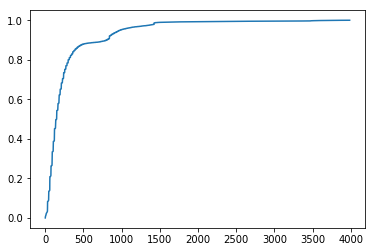

In [17]:
x, y = cdf(tarde.sort_values(by='duration'))
plt.plot(x,y)

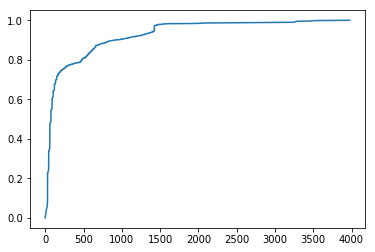

In [18]:
x, y = cdf(noite.sort_values(by='duration'))
plt.plot(x,y)

In [23]:
# Durações menores ou iguais que 28 horas, a fim de facilitar a visualização e eliminar outliers
tarde = tarde[tarde['duration'] <= 28*60]
noite = noite[noite['duration'] <= 28*60]
todos = dfOccupied[dfOccupied['duration'] <= 28*60]

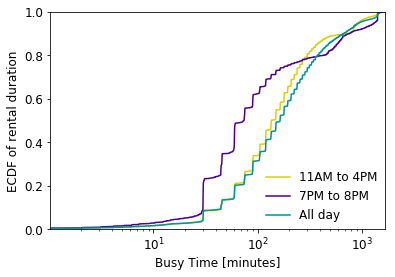

In [24]:
matplotlib.rc('font', size=12)

fig, ax = plt.subplots()

x, y = cdf(tarde.sort_values(by='duration'))
ax.plot(x,y, label='11AM to 4PM', c = '#dbd100')#, marker='o', markevery=[30,280,530,820,1100,1650,2100,2500,
                                                      # 2750,3100,3350,3450])

x, y = cdf(noite.sort_values(by='duration'))
ax.plot(x,y, label='7PM to 8PM', c = '#490092')#, marker='s', markevery=[30,80,120,190,280,340,390,450,465,500])

x, y = cdf(todos.sort_values(by='duration'))
ax.plot(x,y, label='All day', c = '#009292')#, marker='^', markevery=[350,960,1400,2200,2800,3600,4300,5500,
                                                     # 6300,7100,7400])

# Modificando os labels dos minutos
ax.xaxis.set_ticks(np.arange(0, 1800, 180))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,30,3)

ax.set_xticklabels(labels)

ax.legend(loc=4, borderaxespad=0.2, frameon=False)
ax.set_ylabel('ECDF of rental duration')
ax.set_xlabel('Busy Time [minutes]')

# plt.grid(b=True, linestyle='--')
plt.xscale('log')
plt.xlim(min(x),max(x))
plt.ylim(0,1)

plt.savefig('../paper/plots/tarde_noiteCDF_log.pdf', bbox_inches='tight')
# plt.show()